In [1]:
import math
import os
import numpy as np
import cv2 as cv
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from PIL import Image
from kornia_sift import NumpyKorniaSiftDetector
from kornia.filters import gaussian_blur2d

from typing import List, Tuple


def read_img(file_path):
    img_pil = Image.open(file_path)
    img_np = np.array(img_pil)
    return img_np, img_pil


def draw_flipped_kpts(img_np, kpts_original, kpts_to_flip, expected_center, axis_flipped, title):
    new_l = []
    for kpt in kpts_original:
        kpt.size = 50
        kpt.angle = math.pi / 2
    for kpt in kpts_to_flip:
        kp_l = list(kpt.pt)
        kp_l[1 - axis_flipped] = 2 * expected_center - kp_l[1 - axis_flipped]
        size=25
        angle=0
        new_l.append(cv.KeyPoint(kp_l[0], kp_l[1], size, angle=angle))
    kpts_all_cv = list(kpts_original)
    kpts_all_cv.extend(new_l)
    img_kpts = img_np.copy()
    cv.drawKeypoints(img_kpts, kpts_all_cv, img_kpts, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    plt.figure(figsize=(9, 9))
    title = "{}: {} - flipped of size 25, original of size 50".format(title, len(kpts_all_cv))
    plt.title(title)
    plt.imshow(img_kpts)
    plt.show()
    plt.close()


def mnn_generic(pts1, pts2, err_th):

    assert len(pts1.shape) == len(pts2.shape)

    pts1_r, pts2_r = pts1, pts2
    if len(pts1.shape) == 1:
        pts1_r, pts2_r = pts1[:, None].repeat(1, 2), pts2[:, None].repeat(1, 2)
        pts1_r[:, 1] = 0.0
        pts2_r[:, 1] = 0.0

    d_mat = torch.cdist(pts1_r, pts2_r)

    min0_values, min0_indices = torch.min(d_mat, dim=0)
    min1_values, min1_indices = torch.min(d_mat, dim=1)

    mask = min1_indices[min0_indices] == torch.arange(0, min0_indices.shape[0])
    mask2_boolean = mask & (min0_values < err_th)

    verify = True
    if verify:
        for i in range(min0_indices.shape[0]):
            if mask2_boolean[i]:
                assert min1_indices[min0_indices[i]] == i
                assert min0_values[i] < err_th

    mask1 = min0_indices[mask2_boolean]
    pts1_new = pts1[mask1]
    pts2_new = pts2[mask2_boolean]

    mask2 = mask2_boolean.nonzero()[:, 0]
    return pts1_new, pts2_new, mask1, mask2


# copied from kornia, the only change is bilinear subsumpling in the pyramid
# - see the line marked with (***)
class MyScalePyramid(nn.Module):
    r"""Create an scale pyramid of image, usually used for local feature detection.

    Images are consequently smoothed with Gaussian blur and downscaled.

    Args:
        n_levels: number of the levels in octave.
        init_sigma: initial blur level.
        min_size: the minimum size of the octave in pixels.
        double_image: add 2x upscaled image as 1st level of pyramid. OpenCV SIFT does this.

    Returns:
        1st output: images
        2nd output: sigmas (coefficients for scale conversion)
        3rd output: pixelDists (coefficients for coordinate conversion)

    Shape:
        - Input: :math:`(B, C, H, W)`
        - Output 1st: :math:`[(B, C, NL, H, W), (B, C, NL, H/2, W/2), ...]`
        - Output 2nd: :math:`[(B, NL), (B, NL), (B, NL), ...]`
        - Output 3rd: :math:`[(B, NL), (B, NL), (B, NL), ...]`

    Examples:
        >>> input = torch.rand(2, 4, 100, 100)
        >>> sp, sigmas, pds = ScalePyramid(3, 15)(input)
    """

    def __init__(self, n_levels: int = 3, init_sigma: float = 1.6, min_size: int = 15, double_image: bool = False):
        super().__init__()
        # 3 extra levels are needed for DoG nms.
        self.n_levels = n_levels
        self.extra_levels: int = 3
        self.init_sigma = init_sigma
        self.min_size = min_size
        self.border = min_size // 2 - 1
        self.sigma_step = 2 ** (1.0 / float(self.n_levels))
        self.double_image = double_image

    def __repr__(self) -> str:
        return (
            self.__class__.__name__
            + '(n_levels='
            + str(self.n_levels)
            + ', '
            + 'init_sigma='
            + str(self.init_sigma)
            + ', '
            + 'min_size='
            + str(self.min_size)
            + ', '
            + 'extra_levels='
            + str(self.extra_levels)
            + ', '
            + 'border='
            + str(self.border)
            + ', '
            + 'sigma_step='
            + str(self.sigma_step)
            + ', '
            + 'double_image='
            + str(self.double_image)
            + ')'
        )

    def get_kernel_size(self, sigma: float):
        ksize = int(2.0 * 4.0 * sigma + 1.0)

        #  matches OpenCV, but may cause padding problem for small images
        #  PyTorch does not allow to pad more than original size.
        #  Therefore there is a hack in forward function

        if ksize % 2 == 0:
            ksize += 1
        return ksize

    def get_first_level(self, input):
        pixel_distance = 1.0
        cur_sigma = 0.5
        # Same as in OpenCV up to interpolation difference
        if self.double_image:
            x = F.interpolate(input, scale_factor=2.0, mode='bilinear', align_corners=False)
            pixel_distance = 0.5
            cur_sigma *= 2.0
        else:
            x = input
        if self.init_sigma > cur_sigma:
            sigma = max(math.sqrt(self.init_sigma**2 - cur_sigma**2), 0.01)
            ksize = self.get_kernel_size(sigma)
            cur_level = gaussian_blur2d(x, (ksize, ksize), (sigma, sigma))
            cur_sigma = self.init_sigma
        else:
            cur_level = x
        return cur_level, cur_sigma, pixel_distance

    def forward(self, x: torch.Tensor) -> Tuple[List, List, List]:  # type: ignore
        bs, _, _, _ = x.size()
        cur_level, cur_sigma, pixel_distance = self.get_first_level(x)

        sigmas = [cur_sigma * torch.ones(bs, self.n_levels + self.extra_levels).to(x.device).to(x.dtype)]
        pixel_dists = [pixel_distance * torch.ones(bs, self.n_levels + self.extra_levels).to(x.device).to(x.dtype)]
        pyr = [[cur_level]]
        oct_idx = 0
        while True:
            cur_level = pyr[-1][0]
            for level_idx in range(1, self.n_levels + self.extra_levels):
                sigma = cur_sigma * math.sqrt(self.sigma_step**2 - 1.0)
                ksize = self.get_kernel_size(sigma)

                # Hack, because PyTorch does not allow to pad more than original size.
                # But for the huge sigmas, one needs huge kernel and padding...

                ksize = min(ksize, min(cur_level.size(2), cur_level.size(3)))
                if ksize % 2 == 0:
                    ksize += 1

                cur_level = gaussian_blur2d(cur_level, (ksize, ksize), (sigma, sigma))
                cur_sigma *= self.sigma_step
                pyr[-1].append(cur_level)
                sigmas[-1][:, level_idx] = cur_sigma
                pixel_dists[-1][:, level_idx] = pixel_distance
            _pyr = pyr[-1][-self.extra_levels]
            nextOctaveFirstLevel = F.interpolate(
                # (***) THE only change!!! (was "mode='nearest'") - see the comment on the next line
                _pyr, size=(_pyr.size(-2) // 2, _pyr.size(-1) // 2), mode='bilinear'
            )  # Nearest matches OpenCV SIFT
            pixel_distance *= 2.0
            cur_sigma = self.init_sigma
            if min(nextOctaveFirstLevel.size(2), nextOctaveFirstLevel.size(3)) <= self.min_size:
                break
            pyr.append([nextOctaveFirstLevel])
            sigmas.append(cur_sigma * torch.ones(bs, self.n_levels + self.extra_levels).to(x.device))
            pixel_dists.append(pixel_distance * torch.ones(bs, self.n_levels + self.extra_levels).to(x.device))
            oct_idx += 1
        for i in range(len(pyr)):
            pyr[i] = torch.stack(pyr[i], dim=2)  # type: ignore
        return pyr, sigmas, pixel_dists


In [2]:
def reflection_experiment(file_path, detector, axis_flipped, expected_bias):

    axis_not_flipped = 1 - axis_flipped
    img_np_o, img_pil = read_img(file_path)

    kpts_0_cv = detector.detect(img_np_o, mask=None)
    kpts_0 = torch.tensor([[kp.pt[1], kp.pt[0]] for kp in kpts_0_cv])

    img_flipped = np.flip(img_np_o, axis_flipped).copy()
    kpts_1_cv = detector.detect(img_flipped, mask=None)
    kpts_1 = torch.tensor([[kp.pt[1], kp.pt[0]] for kp in kpts_1_cv])
    print("number of kpts: {}, {}".format(kpts_0.shape[0], kpts_1.shape[0]))

    # first perform mnn on the other axis - as seen by the number of filtered points, it's already a good criterion
    kpts_0_new_1d, kpts_1_new_1d, mask_00, mask_10 = mnn_generic(kpts_0[:, axis_not_flipped], kpts_1[:, axis_not_flipped], err_th=1.5)
    print("number of filtered kpts: {}, {}".format(kpts_0_new_1d.shape[0], kpts_1_new_1d.shape[0]))

    distances = (kpts_1_new_1d - kpts_0_new_1d).abs() # only one dimensional
    print("distances in 1D (where mnn was done) - min: {}, max: {}".format(distances.min(), distances.max()))

    # next do mmn in 2D with the filtered kpts - the ones flipped will be flipped back around the expected center
    kpts_0_new, kpts_1_new = kpts_0[mask_00], kpts_1[mask_10]
    expected_center = (img_np_o.shape[axis_flipped] - 1) / 2.0 + expected_bias

    kpts_1_new_flipped_back = torch.clone(kpts_1_new)
    kpts_1_new_flipped_back[:, axis_flipped] = 2 * expected_center - kpts_1_new_flipped_back[:, axis_flipped]
    _, _, mask_01, mask_11 = mnn_generic(kpts_0_new, kpts_1_new_flipped_back, err_th=3.0)
    print("number of filtered kpts: {}".format(mask_01.shape[0]))
    kpts_0_new, kpts_1_new = kpts_0_new[mask_01], kpts_1_new[mask_11]

    def get_lists(i_l, torch_mask):
        m_l = torch_mask.tolist()
        matched_l, unmatched_l = [], []
        for index, item in enumerate(i_l):
            if index in m_l:
                matched_l.append(item)
            else:
                unmatched_l.append(item)
        return matched_l, unmatched_l

    # visualize the matched and umatched keypoints
    kpts_0_cv_matched, kpts_0_cv_unmatched = get_lists(kpts_0_cv, mask_00[mask_01])
    kpts_1_cv_matched, kpts_1_cv_unmatched = get_lists(kpts_1_cv, mask_10[mask_11])
    print("Matched keypoints: {}".format(len(kpts_0_cv_matched) + len(kpts_1_cv_matched)))
    print("Unmatched keypoints: {}".format(len(kpts_0_cv_unmatched) + len(kpts_1_cv_unmatched)))
    #draw_flipped_kpts(img_np_o, kpts_0_cv_matched, kpts_1_cv_matched, expected_center, axis_flipped, "matched keypoints")
    draw_flipped_kpts(img_np_o, kpts_0_cv_unmatched, kpts_1_cv_unmatched, expected_center, axis_flipped, "unmatched keypoints")

    # compute the centers of the symmetry for the matched keypoints, and show stats
    centers_flip_axis = (kpts_0_new[:, axis_flipped] + kpts_1_new[:, axis_flipped]) / 2
    print("symmetry on the other axis (shape={}): min: {}, max: {}".format(img_np_o.shape[axis_flipped], centers_flip_axis.min(), centers_flip_axis.max()))
    mean_centers = centers_flip_axis.mean()
    mean_bias = mean_centers - (img_np_o.shape[axis_flipped] - 1) / 2.0
    var_centers = centers_flip_axis.var()
    print("mean bias: {}, var: {}".format(mean_bias, var_centers))

    
def reflection_experiment_loop(detector, expected_bias, img_to_show):
    for axis_flipped in [0, 1]:
        img_dir = "demo_imgs"
        files = ["{}/{}".format(img_dir, fn) for fn in os.listdir(img_dir)][:img_to_show]
        for file_path in files:
            reflection_experiment(file_path, detector, axis_flipped, expected_bias)



detector: opencv SIFT
number of kpts: 629, 627
number of filtered kpts: 454, 454
distances in 1D (where mnn was done) - min: 0.0, max: 1.0031471252441406
number of filtered kpts: 439
Matched keypoints: 878
Unmatched keypoints: 378


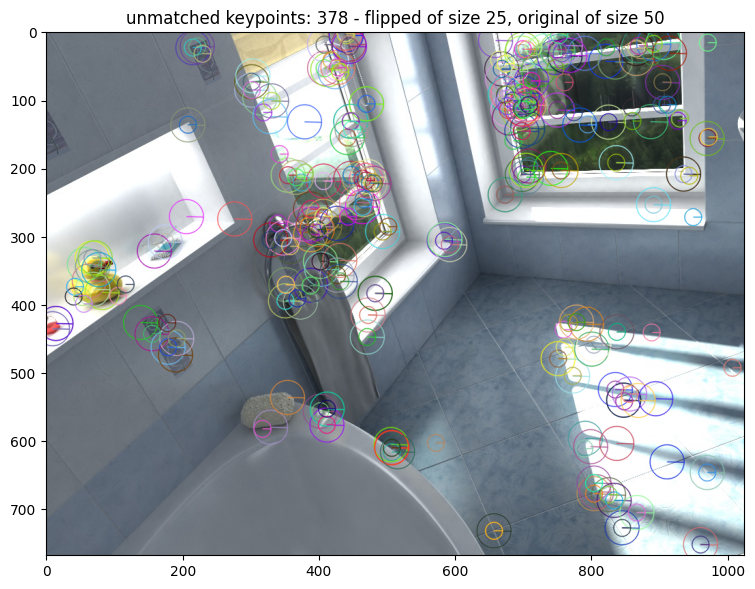

symmetry on the other axis (shape=768): min: 383.48529052734375, max: 383.9348449707031
mean bias: 0.2506103515625, var: 0.0011486512375995517
number of kpts: 272, 267
number of filtered kpts: 187, 187
distances in 1D (where mnn was done) - min: 0.0, max: 0.7311782836914062
number of filtered kpts: 185
Matched keypoints: 370
Unmatched keypoints: 169


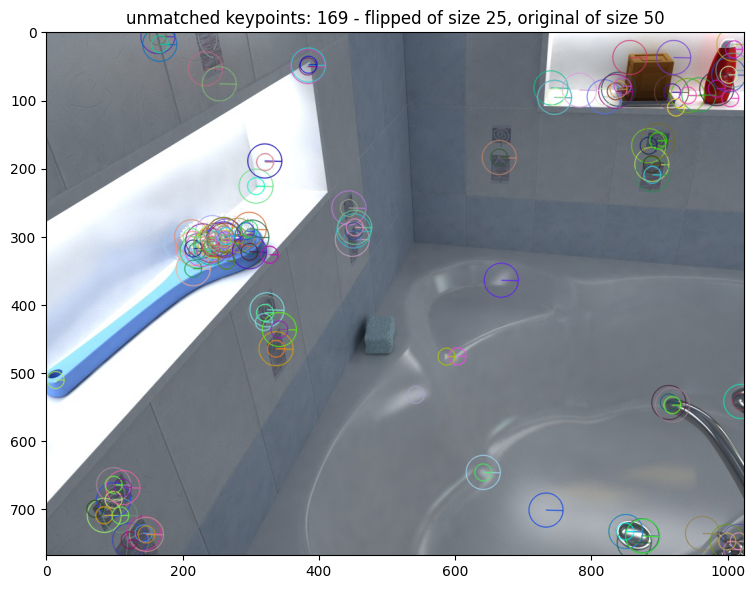

symmetry on the other axis (shape=768): min: 383.2486572265625, max: 384.0206298828125
mean bias: 0.24969482421875, var: 0.003144562942907214
number of kpts: 629, 600
number of filtered kpts: 468, 468
distances in 1D (where mnn was done) - min: 0.0, max: 0.3404541015625
number of filtered kpts: 440
Matched keypoints: 880
Unmatched keypoints: 349


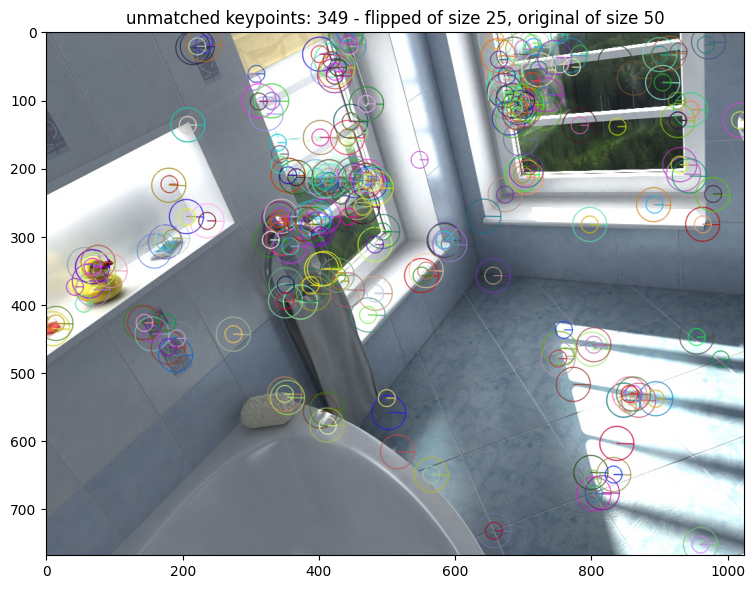

symmetry on the other axis (shape=1024): min: 511.0655212402344, max: 511.89739990234375
mean bias: 0.2510986328125, var: 0.0022404154296964407
number of kpts: 272, 271
number of filtered kpts: 180, 180
distances in 1D (where mnn was done) - min: 0.0, max: 0.535064697265625
number of filtered kpts: 171
Matched keypoints: 342
Unmatched keypoints: 201


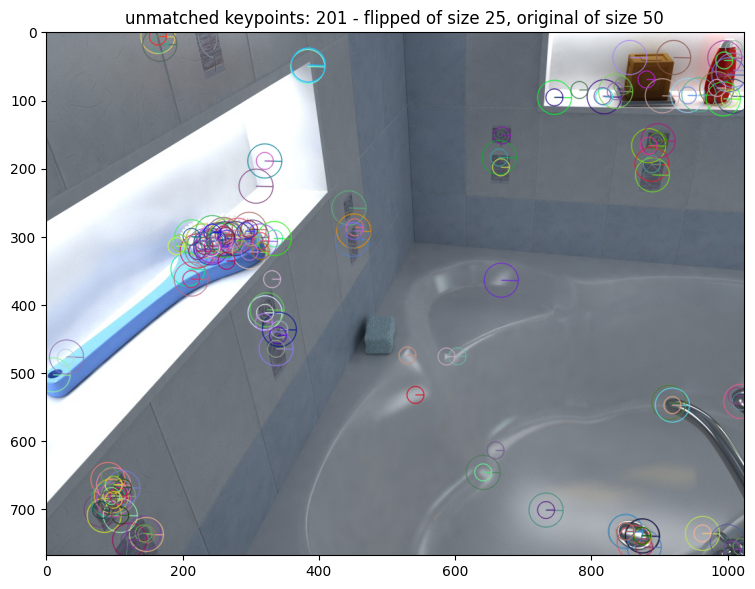

symmetry on the other axis (shape=1024): min: 511.275146484375, max: 511.864990234375
mean bias: 0.243927001953125, var: 0.003738028695806861


In [3]:
print("detector: opencv SIFT")

detector = cv.SIFT_create()
expected_bias = 0.25
reflection_experiment_loop(detector, expected_bias, img_to_show=2)


detector: kornia SIFT
number of kpts: 500, 500
number of filtered kpts: 312, 312
distances in 1D (where mnn was done) - min: 0.0, max: 1.4595184326171875
number of filtered kpts: 236
Matched keypoints: 472
Unmatched keypoints: 528


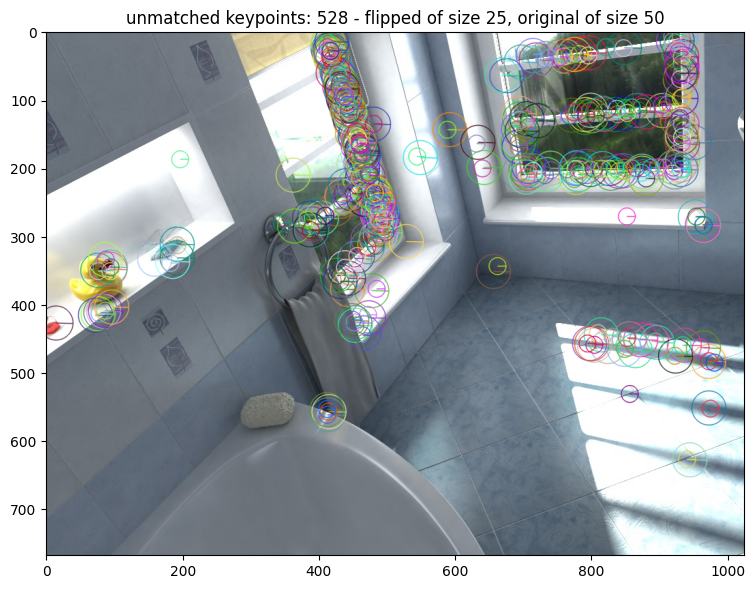

symmetry on the other axis (shape=768): min: 382.5635986328125, max: 385.01959228515625
mean bias: 0.248443603515625, var: 0.07976023107767105
number of kpts: 500, 500
number of filtered kpts: 295, 295
distances in 1D (where mnn was done) - min: 0.0, max: 1.35040283203125
number of filtered kpts: 215
Matched keypoints: 430
Unmatched keypoints: 570


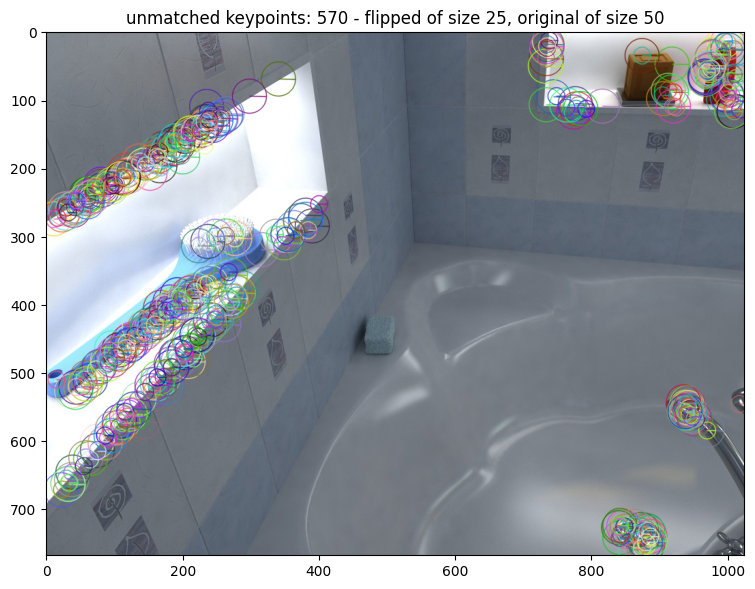

symmetry on the other axis (shape=768): min: 382.4850769042969, max: 384.8205261230469
mean bias: 0.23468017578125, var: 0.07289724797010422
number of kpts: 500, 500
number of filtered kpts: 306, 306
distances in 1D (where mnn was done) - min: 0.0, max: 0.8348388671875
number of filtered kpts: 243
Matched keypoints: 486
Unmatched keypoints: 514


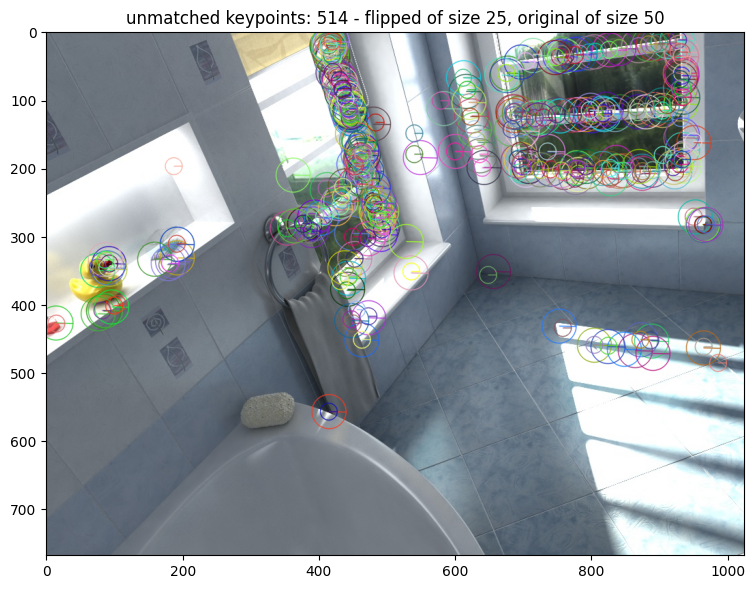

symmetry on the other axis (shape=1024): min: 510.44757080078125, max: 512.9879150390625
mean bias: 0.272430419921875, var: 0.06423044949769974
number of kpts: 500, 500
number of filtered kpts: 309, 309
distances in 1D (where mnn was done) - min: 0.0, max: 1.31134033203125
number of filtered kpts: 233
Matched keypoints: 466
Unmatched keypoints: 534


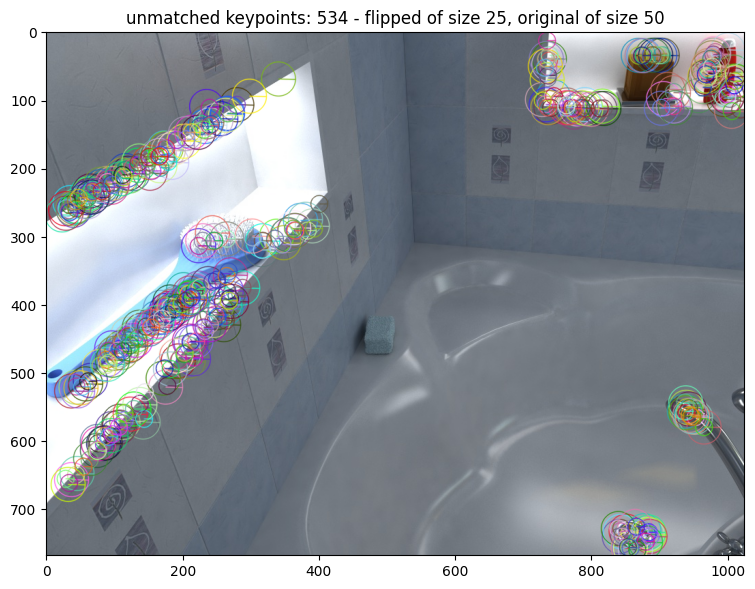

symmetry on the other axis (shape=1024): min: 510.80474853515625, max: 513.112548828125
mean bias: 0.2877197265625, var: 0.08878994733095169


In [4]:
print("detector: kornia SIFT")

detector = NumpyKorniaSiftDetector()
expected_bias = 0.25
reflection_experiment_loop(detector, expected_bias, img_to_show=2)


detector: kornia SIFT with bilinear subsampling
number of kpts: 500, 500
number of filtered kpts: 346, 346
distances in 1D (where mnn was done) - min: 0.0, max: 1.44427490234375
number of filtered kpts: 271
Matched keypoints: 542
Unmatched keypoints: 458


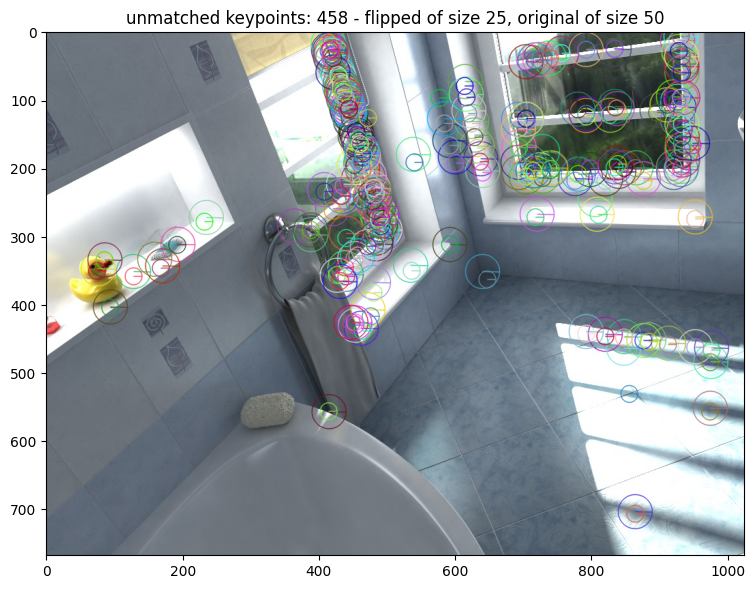

symmetry on the other axis (shape=768): min: 382.0, max: 384.63055419921875
mean bias: 0.0662841796875, var: 0.1037573516368866
number of kpts: 500, 500
number of filtered kpts: 338, 338
distances in 1D (where mnn was done) - min: 0.0, max: 1.1056747436523438
number of filtered kpts: 279
Matched keypoints: 558
Unmatched keypoints: 442


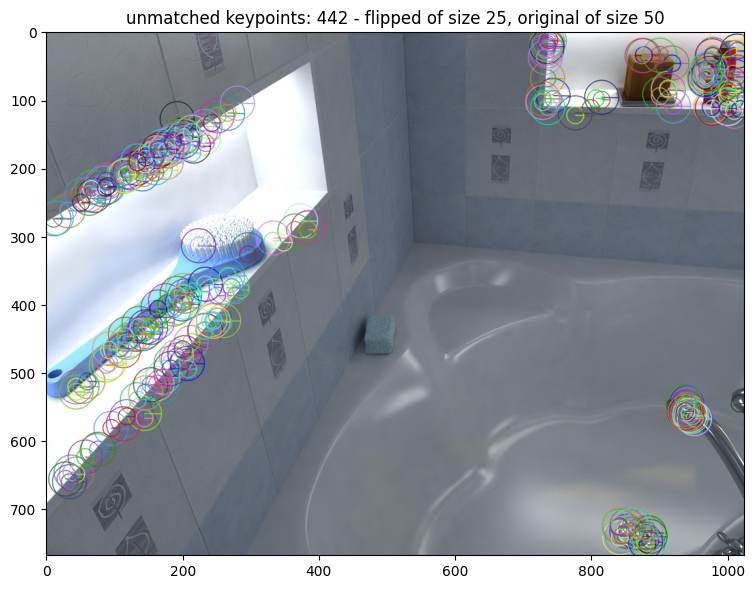

symmetry on the other axis (shape=768): min: 382.73236083984375, max: 384.31390380859375
mean bias: 0.110809326171875, var: 0.039750613272190094
number of kpts: 500, 500
number of filtered kpts: 339, 339
distances in 1D (where mnn was done) - min: 0.0, max: 1.24102783203125
number of filtered kpts: 269
Matched keypoints: 538
Unmatched keypoints: 462


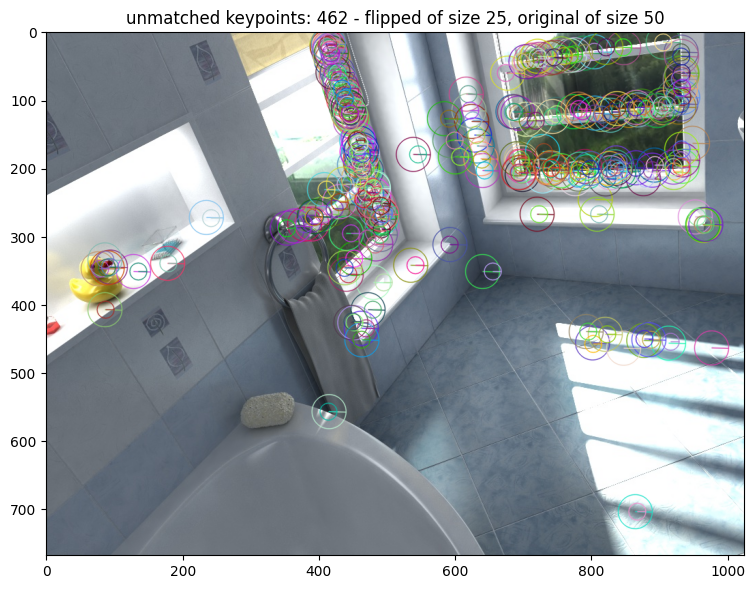

symmetry on the other axis (shape=1024): min: 510.2042236328125, max: 512.8585205078125
mean bias: 0.101470947265625, var: 0.09886620938777924
number of kpts: 500, 500
number of filtered kpts: 370, 370
distances in 1D (where mnn was done) - min: 0.0, max: 1.099365234375
number of filtered kpts: 310
Matched keypoints: 620
Unmatched keypoints: 380


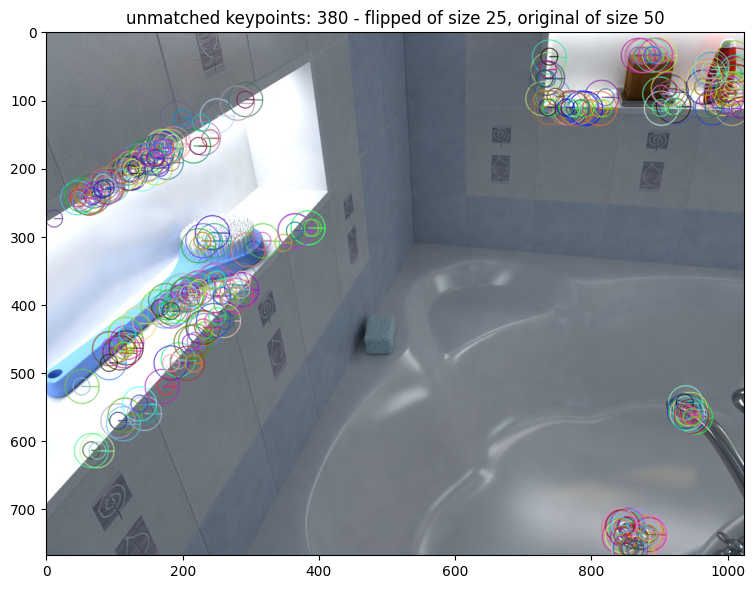

symmetry on the other axis (shape=1024): min: 510.02294921875, max: 512.2936401367188
mean bias: 0.081817626953125, var: 0.05729701370000839


In [5]:
print("detector: kornia SIFT with bilinear subsampling")

custom_scale_pyramid = MyScalePyramid(3, 1.6, 32, double_image=True)
detector = NumpyKorniaSiftDetector(scale_pyramid=custom_scale_pyramid)
expected_bias = 0.0
reflection_experiment_loop(detector, expected_bias, img_to_show=2)
